<a href="https://colab.research.google.com/github/Bustion11/NN-projects/blob/main/ITWGAN/WGANGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Import some true data with transformations.
# For now transforms are ToTensor, and Resize
'''FOOD101 = torchvision.datasets.Food101(
    root = "/data",
    split = "train",
    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize((64, 64))
    ]),
    download = True
)'''

MNIST = torchvision.datasets.MNIST(
    root = "/data",
    train = True,
    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize((64, 64)),
                                    transforms.Normalize([0.5], [0.5])
    ]),
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



In [ ]:
MNIST_loader = DataLoader(MNIST, batch_size=64, shuffle=True)

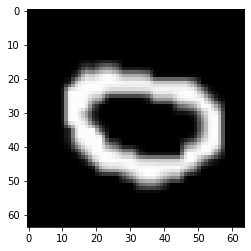

In [ ]:
X, y = next(iter(MNIST_loader))
plt.imshow(X[0][0], cmap="gray")
plt.show()

In [ ]:
print(X.mean())
print(X.std())

tensor(-0.7394)
tensor(0.5775)


In [ ]:
#Critic
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

critic = Critic(1, 4).to("cuda")

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

generator = Generator(100, 1, 4).to("cuda")

In [ ]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

print(gradient_penalty(critic, X.to("cuda"), generator(torch.randn(64, 100, 1, 1).to("cuda")), "cuda"))

tensor(2.1327, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-5, betas=(0.0, 0.9))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.9))

In [ ]:
critic.train()
generator.train()

for _ in range(3):
  for batch, (X, _) in enumerate(MNIST_loader):
    current_size = X.shape[0]
    for _ in range(5):
      noise = torch.randn(current_size, 100, 1, 1, requires_grad=True).to("cuda")
      fake_img = generator(noise)

      critic_real = critic(X.to("cuda")).reshape(-1)
      critic_fake = critic(fake_img.to("cuda")).reshape(-1)

      gp = gradient_penalty(critic, X.to("cuda"), fake_img, device="cuda")

      loss_critic = critic_fake-critic_real+10*gp 
      loss_critic = loss_critic.mean()
      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      critic_optimizer.step()

    fake = generator(torch.randn(current_size, 100, 1, 1, requires_grad=True).to("cuda"))
    gen_loss = -critic(fake).reshape(-1)
    gen_loss = gen_loss.mean()

    generator.zero_grad()
    gen_loss.backward()
    generator_optimizer.step()
    if batch % 100 == 0:
      print("Loss D: ", loss_critic.detach(), " Loss G: ", gen_loss.detach())

print('Finished')

Loss D:  tensor(-0.8698, device='cuda:0')  Loss G:  tensor(34.3869, device='cuda:0')
Loss D:  tensor(-0.3078, device='cuda:0')  Loss G:  tensor(33.0899, device='cuda:0')
Loss D:  tensor(-0.5292, device='cuda:0')  Loss G:  tensor(32.3369, device='cuda:0')
Loss D:  tensor(-0.5986, device='cuda:0')  Loss G:  tensor(33.0308, device='cuda:0')
Loss D:  tensor(-0.6469, device='cuda:0')  Loss G:  tensor(32.5273, device='cuda:0')
Loss D:  tensor(-0.4322, device='cuda:0')  Loss G:  tensor(32.9772, device='cuda:0')
Loss D:  tensor(-0.6742, device='cuda:0')  Loss G:  tensor(31.8390, device='cuda:0')
Loss D:  tensor(-0.6024, device='cuda:0')  Loss G:  tensor(31.4572, device='cuda:0')
Loss D:  tensor(-0.6109, device='cuda:0')  Loss G:  tensor(31.2772, device='cuda:0')
Loss D:  tensor(-0.6321, device='cuda:0')  Loss G:  tensor(31.5305, device='cuda:0')
Loss D:  tensor(-0.5057, device='cuda:0')  Loss G:  tensor(32.3439, device='cuda:0')
Loss D:  tensor(-0.2122, device='cuda:0')  Loss G:  tensor(32.196

In [ ]:
fixed_noise = torch.randn(32, 100, 1, 1).to("cuda")

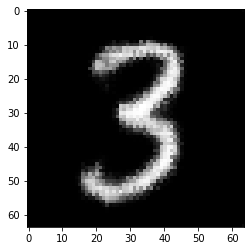

In [ ]:
generator.eval()
with torch.no_grad():
  plt.imshow(generator(fixed_noise)[11][0].cpu(), cmap="gray")
  plt.show()